## 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~
$$

## Setup

In [4]:
# !pip install --upgrade "jax[cuda12]" flax optax dm-haiku jaxtyping clu einops optuna pandas scipy matplotlib seaborn scikit-learn numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 71.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 150.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 118.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 100.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 KB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 KB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.

## PINN

100%|██████████| 1000/1000 [00:03<00:00, 307.01it/s, Loss=1.235228]


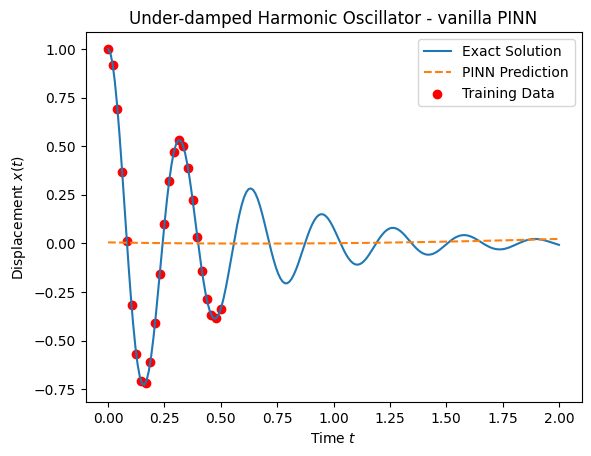

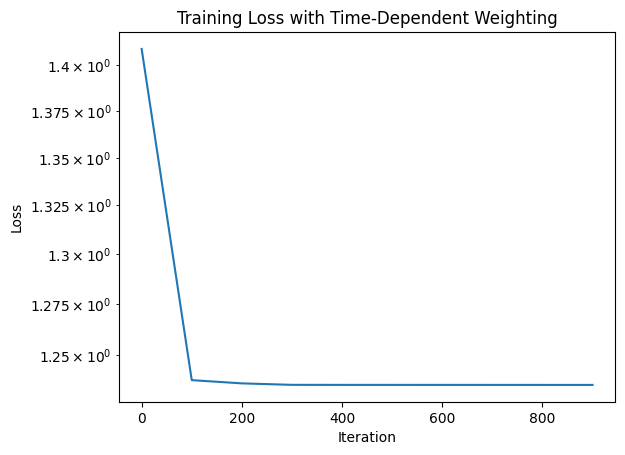

In [1]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the MLP function
def MLP(layers, activation=jnp.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, _ = random.split(key)
            glorot_stddev = 1.0 / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, ijnputs):
        H = ijnputs
        for W, b in params[:-1]:
            outputs = jnp.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(H, W) + b
        return outputs

    return init, apply

# Define the PINN model class with time-dependent weighting
class PINN:
    def __init__(self, key, layers, mu, k, act=jnp.tanh):

        # Initialize the neural network
        self.init, self.apply = MLP(layers, activation=act)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9999999999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = 1.0  # You can adjust this value

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t.reshape(-1, 1))
            return outputs.squeeze()  # Ensure output is a scalar
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)
            x_t = grad(net_apply)(t)
            x_tt = grad(grad(net_apply))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2
        loss_res = jnp.sum(res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2.0*d
k = w0**2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 128, 128, 128, 128, 1]
model = PINN(key, layers, mu, k, act=jax.nn.silu)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Adjust the decay rate as needed
model.lambda_decay = 1.0  # You can experiment with different values

# Train the model
model.train(nIter=1000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator - vanilla PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with Time-Dependent Weighting')
plt.show()


## SPINN

100%|██████████| 1000/1000 [00:02<00:00, 405.38it/s]


Training took 2.47 ms/iter
Relative L2 error on [0, 1.0] ~ 1.62e+00


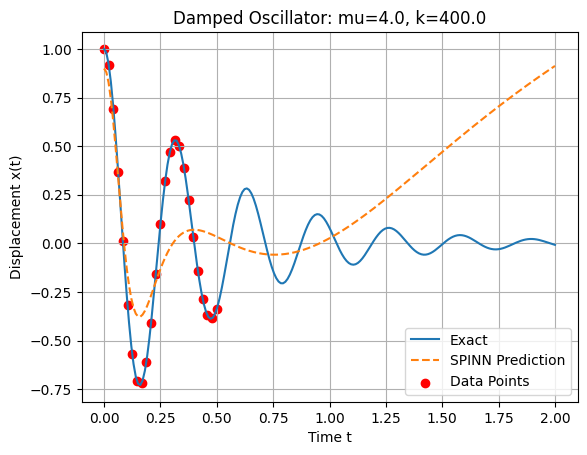

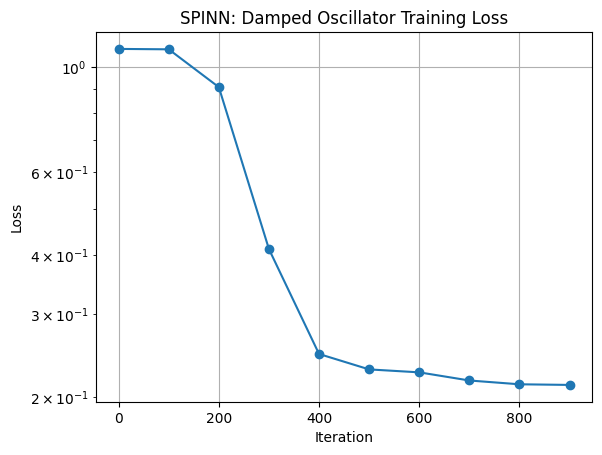

In [2]:
import os
import time
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial

###############################################################################
# 1) SPINN for the damped harmonic oscillator (1D)
###############################################################################
class SPINN_osc(nn.Module):
    """
    SPINN for 1D. We only have one input dimension t.
    `features`: list/tuple specifying widths of each layer.
    Example: features=[64,64,1] => two hidden layers with 64 units each, then output layer with 1 unit.
    """
    features: Sequence[int]

    @nn.compact
    def __call__(self, t):
        """
        t: shape (N,1) or (N,) - we will handle shape carefully
        Returns: shape (N,) or (N,1) for the solution x(t)
        """
        # Just like the original code, we do a feedforward pass:
        # (1) Possibly broadcast t to shape (N,1)
        if t.ndim == 1:
            t = t[:, None]  # shape (N,1)

        init = nn.initializers.glorot_normal()
        X = t
        # hidden layers
        for fs in self.features[:-1]:
            X = nn.Dense(fs, kernel_init=init)(X)
            X = nn.swish(X)
        # final layer
        X = nn.Dense(self.features[-1], kernel_init=init)(X)
        # flatten from (N,1) => (N,)
        return X.squeeze(axis=-1)


###############################################################################
# 2) Hessian-Vector Product for second derivative in 1D
###############################################################################
def hvp_fwdfwd_1d(f, primals, tangents, return_primals=False):
    """
    Forward-mode Hessian-vector product in 1D for PDE residuals.
    This is the same pattern as hvp_fwdfwd in the 3D version, but simplified.
    
    f: function R->R, we want d^2 f/dt^2
    primals: (t,)
    tangents: (1,) usually jnp.ones((N,1)) or broadcast
    """
    g = lambda p: jvp(f, (p,), tangents)[1]  # derivative of f w.r.t p
    primals_out, tangents_out = jvp(g, primals, tangents)
    return (primals_out, tangents_out) if return_primals else tangents_out


###############################################################################
# 3) Loss function for the damped oscillator PDE
###############################################################################
def spinn_loss_damped_oscillator(apply_fn, mu, k):
    """
    PDE: x'' + mu x' + k x = 0
    We define a function that returns PDE-residual + initial cond + data losses.
    """

    def _pde_residual(params, t_c):
        """
        PDE residual over collocation points t_c.
        PDE: x_tt + mu x_t + k x = 0
        """
        # x(t)
        u = apply_fn(params, t_c)  # shape (Nc,)
        # We want second derivative in t.
        # We'll do x_tt via hvp. Also x'(t).
        v = jnp.ones_like(t_c)
        
        # x'(t) = derivative of apply_fn wrt t
        # jvp(f, (t_c,), (v,)) gives df/dt.
        # let's define f(t) = apply_fn(params, t)
        def f(t):
            return apply_fn(params, t)

        # x'(t)
        x_t = jvp(f, (t_c,), (v,))[1]

        # x''(t)
        x_tt = hvp_fwdfwd_1d(f, (t_c,), (v,))

        # PDE residual => x_tt + mu x_t + k x
        res = x_tt + mu * x_t + k * u
        return jnp.mean(res**2)  # MSE over collocation points

    def _initial_loss(params, t0):
        """
        For the oscillator, we typically have x(0)=1, x'(0)=0.
        We'll treat t0 as a single float or 0D array for t=0.
        """
        # x(0)
        x0 = apply_fn(params, t0)  # shape (1,) or scalar
        # x'(0)
        v = jnp.ones_like(t0)  # shape (1,)
        def f(t):
            return apply_fn(params, t)
        x0_t = jvp(f, (t0,), (v,))[1]
        # we want (x(0)-1)^2 + (x'(0) - 0)^2
        return jnp.sum((x0 - 1.0)**2 + (x0_t - 0.0)**2)

    def _data_loss(params, t_d, x_d):
        """
        MSE vs. some known data (maybe from exact solution).
        """
        pred = apply_fn(params, t_d)
        return jnp.mean((pred - x_d)**2)

    def loss_fn(params, t_c, t0, t_d, x_d):
        """
        Combine PDE collocation + initial condition + data matching.
        """
        return 1e-4 * _pde_residual(params, t_c) \
             + _initial_loss(params, t0) \
             + _data_loss(params, t_d, x_d)

    return loss_fn


###############################################################################
# 4) Simple data generator for the damped oscillator
###############################################################################
def spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, key):
    """
    Returns:
      - t_c: collocation points in [0, T]
      - t0: for initial condition
      - t_d, x_d: data points from the exact solution
    """
    # We'll define an "underdamped" oscillator with d>0 => mu=2*d, w0^2 = k, etc.
    # but you can adapt for any damping regime.

    # collocation points
    t_c = jax.random.uniform(key, (n_colloc, 1), minval=0.0, maxval=T).squeeze(-1)  # shape (n_colloc,)
    t_c = jax.lax.stop_gradient(t_c)  # don't backprop through this
    # initial condition at t0=0
    t0 = jnp.array([0.0])  # shape (1,)
    t0 = jax.lax.stop_gradient(t0)  # don't backprop through this

    # data points
    t_d = jnp.linspace(0, T/2, n_data)  # shape (n_data,)
    t_d = jax.lax.stop_gradient(t_d)  # don't backprop through this
    
    # exact solution => x(t) = e^{-d t} * 2A cos(...) or an official formula
    # We'll define a simple function here:
    def exact_solution(t, d, w0):
        # x(t) = e^{-d t} * 2*A*cos(w t + phi)? 
        # For simplicity, let's just do x(0)=1 => 
        # We'll define the same oscillator(d, w0, t) from your prior code:
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0/(2.0*jnp.cos(phi))
        cos_term = jnp.cos(phi + w*t)
        exp_term = jnp.exp(-d*t)
        return exp_term*2*A*cos_term

    # we have mu=2*d => d=mu/2, w0^2=k => w0=jnp.sqrt(k).
    d = mu / 2
    w0 = jnp.sqrt(k)
    x_d = exact_solution(t_d, d, w0)  # shape (n_data,)

    return t_c, t0, t_d, x_d


###############################################################################
# 5) Putting it all together in main()
###############################################################################
def main_damped_oscillator(
    n_colloc=100,
    n_data=25,
    T=1.0,
    mu=4.0,
    k=20.0,
    seed=0,
    lr=1e-3,
    epochs=20000,
    n_layers=4,
    width=64,
    log_iter=2000
):
    """
    Example main function demonstrating how to train the SPINN_osc
    on the damped oscillator PDE: x'' + mu x' + k x = 0.
    """
    # fix GPU usage 
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

    key = jax.random.PRNGKey(seed)
    # network
    feature_sizes = [width]*(n_layers - 1) + [1]  # last layer => 1 output
    model = SPINN_osc(features=feature_sizes)

    # init model
    # We'll initialize with dummy shape (N,1) => let's do N=2
    t_dummy = jnp.ones((2,1))
    params = model.init(key, t_dummy)

    # optimizer
    optim = optax.adam(lr)
    state = optim.init(params)

    # PDE + data
    key, subkey = jax.random.split(key)
    t_c, t0, t_d, x_d = spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, subkey)
    
    # define PDE loss
    apply_fn = partial(model.apply)
    loss_fn = spinn_loss_damped_oscillator(apply_fn, mu, k)

    @partial(jax.jit, static_argnums=(0,))
    def train_step(loss_f, params, state):
        # single step 
        # collocation points, t0, data, etc. are captured from outer scope
        loss, grads = value_and_grad(loss_f)(params, t_c, t0, t_d, x_d)
        updates, state = optim.update(grads, state)
        params = optax.apply_updates(params, updates)
        return loss, params, state

    # training loop
    losses = []
    tic = time.time()
    for i in trange(1, epochs+1):
        loss_val, params, state = train_step(loss_fn, params, state)
        if i % log_iter == 0:
            losses.append(float(loss_val))
        #     print(f"Epoch {i}/{epochs}, Loss = {loss_val:.5e}")
    toc = time.time()
    print(f"Training took {(toc - tic)/epochs*1000:.2f} ms/iter")

    # final solution + plots
    # Evaluate on a test grid
    t_test = jnp.linspace(0.0, 2*T, 200)
    x_pred = apply_fn(params, t_test)  # shape (200,)

    # Compare with exact solution
    d = mu / 2
    w0 = jnp.sqrt(k)
    def exact_solution(t, d, w0):
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0/(2.0*jnp.cos(phi))
        cos_term = jnp.cos(phi + w*t)
        exp_term = jnp.exp(-d*t)
        return exp_term*2*A*cos_term

    x_exact = exact_solution(t_test, d, w0)
    # L2 error
    l2_rel = jnp.linalg.norm(x_pred - x_exact)/jnp.linalg.norm(x_exact)
    print(f"Relative L2 error on [0, {T}] ~ {l2_rel:.2e}")

    # quick plot
    plt.figure()
    plt.plot(t_test, x_exact, label='Exact')
    plt.plot(t_test, x_pred, '--', label='SPINN Prediction')
    plt.scatter(t_d, x_d, color='red', label='Data Points')
    plt.title(f"Damped Oscillator: mu={mu}, k={k}")
    plt.xlabel("Time t")
    plt.ylabel("Displacement x(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot losses
    plt.figure()
    plt.plot(np.arange(len(losses))*log_iter, losses, 'o-')
    plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("SPINN: Damped Oscillator Training Loss")
    plt.grid(True)
    plt.show()

    return l2_rel


###############################################################################
# 6) Running the script
###############################################################################
if __name__ == "__main__":
    main_damped_oscillator(
        n_colloc=100,
        n_data=25,
        T=1.0,     # final time
        mu=4.0,    # e.g. 2*d => d=2 => mu=4
        k=400.0,   # e.g. w0^2=400 => w0=20
        seed=1234,
        lr=1e-3,
        epochs=1000,
        n_layers=4,
        width=128,
        log_iter=100
    )


## MAMBA PINN (dev)

100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s, Loss=1.5598892]


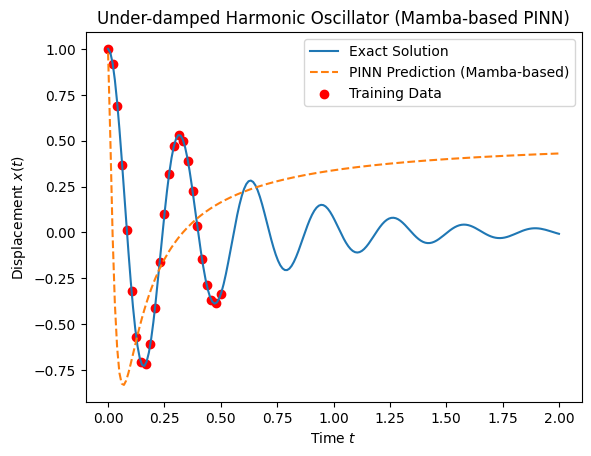

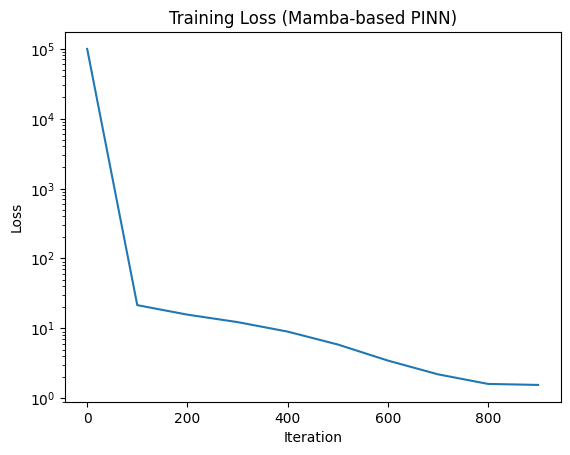

In [3]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

################################################################################
#                   MAMBA-PINN (Adapted for continuous inputs)                  #
################################################################################

from dataclasses import dataclass
from typing import Union
import math

import flax
from flax import linen as nn
from flax.linen.initializers import normal as flax_normal

@dataclass
class ModelArgs:
    """
    We will adapt Mamba's arguments to a simple continuous input use-case
    and produce a single output dimension. 
    """
    d_model: int       # hidden dim
    n_layer: int       # number of layers
    d_state: int = 16  # latent state dim
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4 
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)


class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,))
        normed = x * jax.lax.rsqrt(jnp.mean(x**2, axis=-1, keepdims=True) + self.eps)
        return normed * weight


class MambaBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.in_proj = nn.Dense(
            features=self.args.d_inner * 2,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )
        # Depthwise convolution
        self.conv1d = nn.Conv(
            features=self.args.d_inner,
            kernel_size=[self.args.d_conv],
            feature_group_count=self.args.d_inner,
            padding=self.args.d_conv - 1,
            use_bias=self.args.conv_bias
        )
        # x_proj: produces input-specific Δ, B, C
        self.x_proj = nn.Dense(self.args.dt_rank + self.args.d_state * 2, use_bias=False)
        # dt_proj: projects Δ from dt_rank to d_in
        self.dt_proj = nn.Dense(self.args.d_inner, use_bias=True)

        A = jnp.tile(jnp.arange(1, self.args.d_state + 1), (self.args.d_inner, 1))
        self.A_log = self.param('A_log', lambda rng, shape: jnp.log(A), (self.args.d_inner, self.args.d_state))
        self.D = self.param('D', nn.initializers.ones, (self.args.d_inner,))
        self.out_proj = nn.Dense(
            features=self.args.d_model,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )

    def __call__(self, x):
        """
        x: (batch, length, d_model)
        Returns: (batch, length, d_model)
        """
        b, l, d = x.shape

        # in_proj => (b, l, 2 * d_inner)
        x_and_res = self.in_proj(x)

        # Split into x, res
        x_part, res = jnp.split(x_and_res, [self.args.d_inner], axis=-1)

        # Depthwise conv => (b, l, d_inner)
        x_part = self.conv1d(x_part)[:, :l, :]

        x_part = jax.nn.silu(x_part) # original Mamba uses SiLU

        # SSM forward pass => (b, l, d_inner)
        y = self.ssm(x_part)

        # Gating => (b, l, d_inner)
        y = y * jax.nn.silu(res) # original Mamba uses SiLU

        # Project back => (b, l, d_model)
        out = self.out_proj(y)
        return out

    def ssm(self, x):
        """
        x: (b, l, d_in) with d_in = d_inner
        Returns: (b, l, d_in)
        """
        d_in, n = self.A_log.shape
        b, l, _ = x.shape

        # A, D input independent
        A = -jnp.exp(self.A_log)  # (d_in, n)
        D = self.D                # (d_in,)

        # x_proj => (b, l, dt_rank + 2*n)
        x_dbl = self.x_proj(x)
        # delta: (b, l, dt_rank), B,C: (b, l, n)
        delta, B, C = jnp.split(x_dbl, [self.args.dt_rank, self.args.dt_rank + n], axis=-1)

        # softplus => positive step sizes
        delta = jax.nn.softplus(self.dt_proj(delta))  # => (b, l, d_in)

        # Selective scan => (b, l, d_in)
        return self.selective_scan(x, delta, A, B, C, D)

    def selective_scan(self, u, delta, A, B, C, D):
        """
        Discretized state space scan across the time dimension.
        u:     (b, l, d_in)
        delta: (b, l, d_in)
        A:     (d_in, n)
        B,C:   (b, l, n)
        D:     (d_in,)
        """
        b, l, d_in = u.shape
        n = A.shape[1]

        # Discretize
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bln,bld->bldn', delta, B, u)

        x_state = jnp.zeros((b, d_in, n))
        ys = []
        for i in range(l):
            x_state = deltaA[:, i] * x_state + deltaB_u[:, i]
            y_i = jnp.einsum('bdn,bn->bd', x_state, C[:, i, :])

            ys.append(y_i)
        y = jnp.stack(ys, axis=1)  # => (b, l, d_in)

        y = y + u * D
        return y


class ResidualBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.mixer = MambaBlock(self.args)
        self.norm = RMSNorm(self.args.d_model)

    def __call__(self, x):
        """
        x: (b, l, d_model)
        """
        return self.mixer(self.norm(x)) + x


class MambaForPINNModel(nn.Module):
    """
    Minimal Mamba that accepts continuous inputs of shape (batch, length, 1)
    and outputs shape (batch, length, 1).

    We'll have multiple residual blocks + final projection to 1D output.
    """
    args: ModelArgs

    def setup(self):
        # A small linear "embedding" from 1 -> d_model
        self.input_proj = nn.Dense(features=self.args.d_model)
        # stack of n_layer Mamba residual blocks
        self.layers = [ResidualBlock(self.args) for _ in range(self.args.n_layer)]
        self.norm_final = RMSNorm(self.args.d_model)
        # final linear from d_model -> 1
        self.output_proj = nn.Dense(features=1)

    def __call__(self, x):
        """
        x: (b, l, 1) -- times
        returns: (b, l, 1)
        """
        # Project up to d_model
        x = self.input_proj(x)
        # Pass through Mamba layers
        for layer in self.layers:
            x = layer(x)
        x = self.norm_final(x)
        # Project down to 1
        y = self.output_proj(x)
        return y


def MambaForPINN(d_model=16, n_layer=2):
    """
    Create `init` and `apply` callables (mimicking the old MLP signature).
    The network will take shape (n,1) and produce (n,1) as outputs,
    using a minimal Mamba-based architecture inside.
    """
    args = ModelArgs(
        d_model=d_model,
        n_layer=n_layer,
        # the rest can remain default
    )
    model = MambaForPINNModel(args)

    def init_fcn(rng_key):
        # We'll do a dummy input shape (1, 1, 1) just to initialize
        dummy_input = jnp.zeros((1, 1, 1))
        return model.init(rng_key, dummy_input)

    def apply_fcn(params, x):
        # x: shape (n,) for time points -> reshape to (n,1,1)
        x_reshaped = x.reshape(-1, 1, 1)
        y = model.apply(params, x_reshaped)  # (n,1,1)
        return y.squeeze(axis=-1)           # => (n,1)

    return init_fcn, apply_fcn

################################################################################
#                          PINN CODE (MLP replaced)                            #
################################################################################

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class with time-dependent weighting
class PINN:
    def __init__(self, key, d_model, n_layer, mu, k):

        # ~~~ REPLACEMENT: Use Mamba for PINN instead of MLP ~~~
        self.init, self.apply = MambaForPINN(d_model=d_model, n_layer=n_layer)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

        # Constants for oscillator
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = 1.0  # You can adjust this value

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t)  # shape (n,1) if t is shape (n,)
            return outputs.squeeze()         # make sure each scalar is returned
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)         # x(t)
            x_t = grad(net_apply)(t) # dx/dt
            x_tt = grad(grad(net_apply))(t) # d^2x/dt^2
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2
        # loss_res = jnp.sum(res_squared)

        # Time-dependent weights
        weights_time = jnp.exp(-self.lambda_decay * t_r)
        weights_time /= jnp.sum(weights_time)  # Normalize weights
        weights = weights_time
        weights /= jnp.sum(weights)

        loss_res = jnp.sum(weights * res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4 * loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(
                self.current_count, self.opt_state, t_r, t_data, x_data
            )
            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
mu = 40.
k = 400.

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)   # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25) # Data points for initial training
x_data = oscillator(d, w0, t_data)  # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
model = PINN(key, d_model=128, n_layer=4, mu=mu, k=k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Adjust the decay rate as needed
model.lambda_decay = 1.0  # You can experiment with different values

# Train the model
model.train(nIter=1000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction (Mamba-based)')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator (Mamba-based PINN)')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss (Mamba-based PINN)')
plt.show()


## MAMBA SPINN (dev)

In [1]:
import os
import time
import math
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from flax.linen.initializers import normal as flax_normal
from dataclasses import dataclass
from typing import Union, Sequence
from functools import partial

################################################################################
#                           Mamba-PINN ARCHITECTURE
################################################################################

@dataclass
class ModelArgs:
    """
    Adapt Mamba's arguments for a continuous input (e.g. time) -> single output.
    """
    d_model: int
    n_layer: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)


class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,))
        normed = x * jax.lax.rsqrt(jnp.mean(x**2, axis=-1, keepdims=True) + self.eps)
        return normed * weight


class MambaBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.in_proj = nn.Dense(
            features=self.args.d_inner * 2,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )
        # Depthwise convolution
        self.conv1d = nn.Conv(
            features=self.args.d_inner,
            kernel_size=[self.args.d_conv],
            feature_group_count=self.args.d_inner,
            padding=self.args.d_conv - 1,
            use_bias=self.args.conv_bias
        )
        self.x_proj = nn.Dense(self.args.dt_rank + self.args.d_state * 2, use_bias=False)
        self.dt_proj = nn.Dense(self.args.d_inner, use_bias=True)

        # Parameter A_log, D
        A = jnp.tile(jnp.arange(1, self.args.d_state + 1), (self.args.d_inner, 1))
        self.A_log = self.param('A_log', lambda rng, shape: jnp.log(A),
                                (self.args.d_inner, self.args.d_state))
        self.D = self.param('D', nn.initializers.ones, (self.args.d_inner,))

        self.out_proj = nn.Dense(
            features=self.args.d_model,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )

    def __call__(self, x):
        """
        x: (batch, length, d_model)
        Returns: (batch, length, d_model)
        """
        b, l, d = x.shape

        # in_proj => (b, l, 2*d_inner)
        x_and_res = self.in_proj(x)
        x_part, res = jnp.split(x_and_res, [self.args.d_inner], axis=-1)

        # Depthwise conv => (b, l, d_inner)
        x_part = self.conv1d(x_part)[:, :l, :]
        x_part = jax.nn.silu(x_part)

        # SSM forward
        y = self.ssm(x_part)

        # Gating
        y = y * jax.nn.silu(res)

        # Projection back to d_model
        out = self.out_proj(y)
        return out

    def ssm(self, x):
        """
        x: (b, l, d_inner)
        returns: (b, l, d_inner)
        """
        d_in, n = self.A_log.shape
        b, l, _ = x.shape

        A = -jnp.exp(self.A_log)
        D = self.D

        # x_proj => split => delta, B, C
        x_dbl = self.x_proj(x)
        delta, B, C = jnp.split(
            x_dbl,
            [self.args.dt_rank, self.args.dt_rank + n],
            axis=-1
        )
        # step sizes
        delta = jax.nn.softplus(self.dt_proj(delta))  # (b,l,d_in)

        return self.selective_scan(x, delta, A, B, C, D)

    def selective_scan(self, u, delta, A, B, C, D):
        """
        discrete state-space scan across time dimension
        u: (b,l,d_in)
        delta: (b,l,d_in)
        A: (d_in,n), B: (b,l,n), C: (b,l,n), D: (d_in,)
        """
        b, l, d_in = u.shape
        n = A.shape[1]

        # discretize
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bln,bld->bldn', delta, B, u)

        x_state = jnp.zeros((b, d_in, n))
        ys = []
        for i in range(l):
            x_state = deltaA[:, i] * x_state + deltaB_u[:, i]
            y_i = jnp.einsum('bdn,bn->bd', x_state, C[:, i, :])
            ys.append(y_i)
        y = jnp.stack(ys, axis=1)  # => (b,l,d_in)
        # add skip
        y = y + u * D
        return y


class ResidualBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.mixer = MambaBlock(self.args)
        self.norm = RMSNorm(self.args.d_model)

    def __call__(self, x):
        return self.mixer(self.norm(x)) + x


class MambaForPINNModel(nn.Module):
    """
    Minimal Mamba that accepts shape (b, l, input_dim) -> (b, l, 1).
    """
    args: ModelArgs
    input_dim: int = 1

    def setup(self):
        self.input_proj = nn.Dense(self.args.d_model)
        self.layers = [ResidualBlock(self.args) for _ in range(self.args.n_layer)]
        self.norm_final = RMSNorm(self.args.d_model)
        self.output_proj = nn.Dense(1)

    def __call__(self, x):
        # x: (b, l, input_dim)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm_final(x)
        return self.output_proj(x)


def MambaForPINN(d_model=16, n_layer=2, input_dim=1):
    """
    Returns init_fn, apply_fn for the Mamba network.
    """
    args = ModelArgs(d_model=d_model, n_layer=n_layer)
    model = MambaForPINNModel(args, input_dim=input_dim)

    def init_fcn(rng_key):
        dummy_input = jnp.zeros((1, 1, input_dim))
        return model.init(rng_key, dummy_input)

    def apply_fcn(params, x):
        # x: shape (N, input_dim). Reshape => (N, 1, input_dim) for Mamba
        if x.ndim == 2:
            x_reshaped = x[:, None, :]
        else:
            x_reshaped = x.reshape(-1, 1, input_dim)
        y = model.apply(params, x_reshaped)  # => (N,1,1)
        return y.squeeze(axis=-1).squeeze(axis=-1)  # => shape (N,)

    return init_fcn, apply_fcn

################################################################################
#          SPINN CLASS (using Mamba-based architecture for 1D oscillator)
################################################################################

class MAMBA_SPINN_osc:
    """
    Simple class that holds the Mamba PINN for 1D damped oscillator,
    plus optimizer state. Not a Flax module, just a Python class.
    """
    def __init__(self, d_model=16, n_layer=2, lr=1e-3):
        # Create Mamba architecture
        self.init_fn, self.apply_fn = MambaForPINN(
            d_model=d_model,
            n_layer=n_layer,
            input_dim=1  # single dimension (time)
        )
        # Init params
        rng = jax.random.PRNGKey(0)
        self.params = self.init_fn(rng)
        # Setup optimizer
        self.optimizer = optax.adam(lr)
        self.opt_state = self.optimizer.init(self.params)

    def forward(self, t):
        """
        Evaluate the network for time array t, shape (N,).
        Returns (N,).
        """
        return self.apply_fn(self.params, t)

    def update_params(self, grads):
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)

################################################################################
#     HVP FORWARD-FORWARD: for computing second derivative wrt time in 1D
################################################################################

def hvp_fwdfwd_1d(f, primals, tangents, return_primals=False):
    """
    1D Hessian-vector product for PDE second derivative.
    """
    g = lambda p: jvp(f, (p,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    return (primals_out, tangents_out) if return_primals else tangents_out

################################################################################
#            Loss for damped oscillator PDE: x'' + mu x' + k x = 0
################################################################################

def spinn_loss_damped_oscillator(apply_fn, mu, k):
    """
    Return a function that computes PDE residual + initial + data losses.
    PDE: x_tt + mu x_t + k x = 0
    """
    def _pde_residual(params, t_c):
        # x(t)
        u = apply_fn(params, t_c)
        v = jnp.ones_like(t_c)  # for derivative
        def f(t):
            return apply_fn(params, t)

        # 1st derivative x'(t)
        x_t = jvp(f, (t_c,), (v,))[1]
        # 2nd derivative x''(t)
        x_tt = hvp_fwdfwd_1d(f, (t_c,), (v,))

        res = x_tt + mu * x_t + k * u
        return jnp.mean(res**2)

    def _initial_loss(params, t0):
        # x(0)=1, x'(0)=0
        x0 = apply_fn(params, t0)
        v = jnp.ones_like(t0)
        def f(t):
            return apply_fn(params, t)
        x0_t = jvp(f, (t0,), (v,))[1]
        return ((x0 - 1.0)**2 + (x0_t - 0.0)**2).sum()

    def _data_loss(params, t_d, x_d):
        pred = apply_fn(params, t_d)
        return jnp.mean((pred - x_d)**2)

    def loss_fn(params, t_c, t0, t_d, x_d):
        return 1e-4 * _pde_residual(params, t_c) \
             + _initial_loss(params, t0) \
             + _data_loss(params, t_d, x_d)

    return loss_fn

################################################################################
#                 Generate training data for the damped oscillator
################################################################################

def spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, key):
    """
    Returns t_c, t0, t_d, x_d for PDE training:
      - t_c: collocation points in [0,T]
      - t0: array [0.] for initial condition
      - t_d, x_d: data points from exact solution
    """
    t_c = jax.random.uniform(key, (n_colloc,), minval=0.0, maxval=T)
    t0 = jnp.array([0.0])
    t_d = jnp.linspace(0, T/2, n_data)

    # exact solution
    d = mu / 2
    w0 = jnp.sqrt(k)
    def exact_solution(t):
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0 / (2.0 * jnp.cos(phi))
        return jnp.exp(-d*t)*2*A*jnp.cos(phi + w*t)

    x_d = exact_solution(t_d)
    return t_c, t0, t_d, x_d

################################################################################
#                   Main function: Training the MAMBA SPINN
################################################################################

def main_damped_oscillator(
    n_colloc=64,
    n_data=25,
    T=1.0,
    mu=4.0,
    k=20.0,
    seed=0,
    lr=1e-3,
    epochs=20000,
    n_layers=4,
    width=64,
    log_iter=2000
):
    """
    Example of training the 1D damped oscillator PDE with Mamba-based SPINN.
    """
    # fix GPU usage
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

    # 1) Build the MAMBA SPINN
    # We'll pass d_model=width, n_layer=n_layers, lr=lr, etc.
    model = MAMBA_SPINN_osc(d_model=width, n_layer=n_layers, lr=lr)

    # 2) Generate data
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    t_c, t0, t_d, x_d = spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, subkey)

    # 3) Build PDE loss
    loss_fn = spinn_loss_damped_oscillator(model.apply_fn, mu, k)

    @partial(jax.jit, static_argnums=(0,))
    def train_step(loss_f, params, opt_state):
        loss, grads = value_and_grad(loss_f)(params, t_c, t0, t_d, x_d)
        updates, opt_state = model.optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # 4) Training loop
    losses = []
    tic = time.time()
    for i in trange(1, epochs+1):
        loss_val, model.params, model.opt_state = train_step(loss_fn, model.params, model.opt_state)
        if i % log_iter == 0:
            losses.append(float(loss_val))
            # print(f"[Epoch {i}] Loss = {loss_val:.5e}")
    toc = time.time()
    print(f"Training took {(toc - tic)/epochs*1000:.2f} ms/iter")

    # 5) Evaluate final solution
    t_test = jnp.linspace(0.0, T, 200)
    x_pred = model.apply_fn(model.params, t_test)

    # exact solution
    d = mu / 2
    w0 = jnp.sqrt(k)
    def exact_solution(t):
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0/(2.0*jnp.cos(phi))
        return jnp.exp(-d*t)*2*A*jnp.cos(phi + w*t)

    x_exact = exact_solution(t_test)
    l2_rel = jnp.linalg.norm(x_pred - x_exact)/jnp.linalg.norm(x_exact)
    print(f"Relative L2 error ~ {l2_rel:.2e}")

    # 6) Plot results
    plt.figure()
    plt.plot(t_test, x_exact, label='Exact')
    plt.plot(t_test, x_pred, '--', label='MAMBA-SPINN')
    plt.scatter(t_d, x_d, color='red', label='Data')
    plt.xlabel('Time t')
    plt.ylabel('Displacement x(t)')
    plt.title(f"Damped Oscillator: mu={mu}, k={k}, L2={l2_rel:.2e}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot losses
    plt.figure()
    iters_logged = np.arange(len(losses)) * log_iter
    plt.plot(iters_logged, losses, 'o-')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title("MAMBA-SPINN Training Loss")
    plt.grid(True)
    plt.show()

    return l2_rel


if __name__ == "__main__":
    # Example usage
    main_damped_oscillator(
        n_colloc=100,
        n_data=25,
        T=1.0,
        mu=4.0,
        k=400.0,
        seed=1234,
        lr=1e-3,
        epochs=1000,
        n_layers=4,
        width=128,
        log_iter=100
    )


 15%|█▌        | 150/1000 [00:33<03:11,  4.44it/s]


KeyboardInterrupt: 

## PIKAN

In [7]:
import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.KAN import KAN


# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class using KAN
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the KAN model
        self.model = KAN(layer_dims=layers, add_bias=True)

        # Initialize parameters and state
        rng, init_rng = random.split(key)
        # Use a dummy ijnput to initialize the model
        x_init = jnp.array([[0.0]])  # Shape (1, 1)
        variables = self.model.init(init_rng, x_init)
        self.params = variables['params']
        self.state = variables.get('state', {})

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

    def net_apply(self, params, x):
        outputs, _ = self.model.apply({'params': params, 'state': self.state}, x)
        return outputs.squeeze()  # Ensure output is a scalar

    def neural_net(self, params):
        # Define a function that can be differentiated
        def net_fn(t):
            x = t.reshape(-1, 1)
            return self.net_apply(params, x)
        return net_fn

    def residual_net(self, params):
        net_fn = self.neural_net(params)
        def res_fn(t):
            x = net_fn(t)
            x_t = grad(net_fn)(t)
            x_tt = grad(grad(net_fn))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_fn

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss
        res_fn = self.residual_net(params)
        res = vmap(res_fn)(t_r)
        res_squared = res ** 2

        # Compute attention weights based on residuals (optional)
        weights = res_squared / jnp.sum(res_squared)
        loss_res = jnp.sum(weights * res_squared)

        # Or use unweighted residual loss
        # loss_res = jnp.mean(res_squared)

        # Data loss (at observed data points)
        net_fn = self.neural_net(params)
        x_pred = vmap(net_fn)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_fn(jnp.array(0.0))
        x0_t_pred = grad(net_fn)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 25, 25, 1]  # Adjust the layers as needed
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Train the model
model.train(nIter=1000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_fn = model.neural_net(params)
x_pred = vmap(net_fn)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='KAN PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with KAN PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with KAN PINN')
plt.show()


AttributeError: 'KAN' object has no attribute 'init'

## SPIKAN (dev)

In [ ]:
#  --  implementation in progress  --